In [1]:
from google.colab import files
uploaded = files.upload()

Saving spring-osc-trim.mov to spring-osc-trim.mov


In [2]:
import cv2
import torch
import os
import numpy as np

video_path = "spring-osc-trim.mov"

cap = cv2.VideoCapture(video_path)

frame_list = []

frame_skip = 3
resize_to = (128, 128)
i = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if i % frame_skip == 0:
        frame_resized = cv2.resize(frame, resize_to)
        frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
        frame_tensor = torch.tensor(frame_gray / 255.0, dtype=torch.float32).unsqueeze(0)
        frame_list.append(frame_tensor)
    i += 1

cap.release()

images_tensor = torch.stack(frame_list)
print(f"Processed tensor shape: {images_tensor.shape}")

torch.save(images_tensor, "image_tensors.pt")

Processed tensor shape: torch.Size([372, 1, 128, 128])


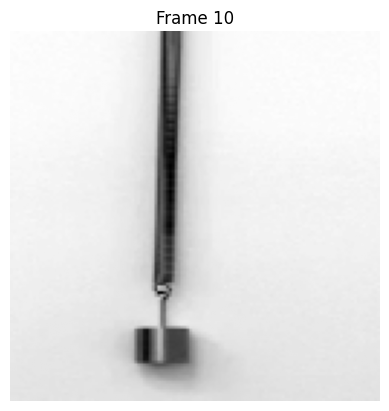

In [3]:
import matplotlib.pyplot as plt

frame_idx = 10

frame = images_tensor[frame_idx].squeeze(0).numpy()

plt.imshow(frame.T, cmap='gray')
plt.title(f"Frame {frame_idx}")
plt.axis('off')
plt.show()

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

class KoopmanAutoencoder(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(KoopmanAutoencoder, self).__init__()

        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )

        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, latent_dim),
        )

        self.K = nn.Linear(latent_dim, latent_dim, bias=False)

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def _get_conv_output(self, shape):
        input_tensor = torch.randn(1, *shape)
        with torch.no_grad():
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]
        n_size = output_feat.detach().flatten(start_dim=1).size(1)
        self.num_flat_features = n_size

    def forward(self, x, apply_koopman=False, m=0):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()
        x = self.decoder_fc_layers(x)
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        if apply_koopman:
            latent_vars_at_m = latent_vars
            for i in range(m):
                latent_vars_at_m = self.K(latent_vars_at_m)
            decoded_k = self.decoder_fc_layers(latent_vars_at_m)
            decoded_k = decoded_k.view(decoded_k.size(0), *self.final_conv_shape)
            decoded_k = self.decoder_conv_layers(decoded_k)
            return decoded_k, latent_vars_at_m
        return x, latent_vars

In [10]:
# Initialize model
sample_shape = tuple(images_tensor[0].shape)
model = KoopmanAutoencoder(input_shape=sample_shape)

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
images_tensor = torch.load('/content/image_tensors.pt')
X_current = images_tensor[:-1]
X_future = images_tensor[1:]

# Training loop
num_epochs = 50

def train_combined_with_physics(alpha=0.0292, beta=0.0025, lambda_phys=10, lambda_damp=5, lambda_energy=5, lambda_orth=1, smooth_weight=0.1):
    model.train()
    latent_vars_no_k_history = []
    latent_vars_k_history = []

    for epoch in range(num_epochs):
        total_loss = 0
        optimizer.zero_grad()

        reconstructed, latent_vars = model(images_tensor)
        reconstructed = reconstructed[:, :, :images_tensor.shape[2], :images_tensor.shape[3]]
        autoencoder_loss = loss_fn(reconstructed, images_tensor)

        koopman_loss = 0
        for i in range(len(X_current)):
            x_at_i_plus_m, latent_at_i_plus_m = model(X_future[i].unsqueeze(0))
            reconstructed_k, latent_at_i_plus_m_with_K = model(X_current[i].unsqueeze(0), True, 1)
            reconstructed_k = reconstructed_k[:, :, :images_tensor.shape[2], :images_tensor.shape[3]]

            koopman_loss += loss_fn(latent_at_i_plus_m, latent_at_i_plus_m_with_K)
            koopman_loss += loss_fn(X_future[i].unsqueeze(0), reconstructed_k)

            if epoch == num_epochs - 1:
                latent_vars_no_k_history.append(latent_at_i_plus_m.detach().cpu().numpy())
                latent_vars_k_history.append(latent_at_i_plus_m_with_K.detach().cpu().numpy())

        koopman_loss /= len(X_current)

        latent_x = latent_vars[:, 0]
        latent_v = latent_vars[:, 1]

        dx_dt = latent_x[1:] - latent_x[:-1]
        v_trim = latent_v[:-1]
        phys_loss = lambda_phys * F.mse_loss(dx_dt, v_trim)

        dv_dt = latent_v[1:] - latent_v[:-1]
        x_trim = latent_x[1:]
        v_trim2 = latent_v[1:]
        expected_acc = -alpha * x_trim - beta * v_trim2
        damp_loss = lambda_damp * F.mse_loss(dv_dt, expected_acc)

        energy = latent_x**2 + latent_v**2
        energy_diff = energy[1:] - energy[:-1]
        energy_decay_loss = lambda_energy * F.relu(energy_diff).mean()

        orthogonality_loss = lambda_orth * torch.mean(latent_x * latent_v)

        smooth = torch.mean((latent_vars[1:] - latent_vars[:-1])**2) * smooth_weight

        total_loss = autoencoder_loss + koopman_loss + phys_loss + damp_loss + energy_decay_loss + orthogonality_loss + smooth

        total_loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    latent_vars_k_history = np.vstack(latent_vars_k_history)
    latent_vars_no_k_history = np.vstack(latent_vars_no_k_history)

    return latent_vars_no_k_history, latent_vars_k_history

In [11]:
latent_vars_no_k_history, latent_vars_k_history = train_combined_with_physics()

Epoch: 0, Total Loss: 1.5038
Epoch: 1, Total Loss: 341.2001
Epoch: 2, Total Loss: 8.2407
Epoch: 3, Total Loss: 85.6442
Epoch: 4, Total Loss: 31.7282
Epoch: 5, Total Loss: 3.8626
Epoch: 6, Total Loss: 41.1233
Epoch: 7, Total Loss: 37.1334
Epoch: 8, Total Loss: 12.7106
Epoch: 9, Total Loss: 1.9684
Epoch: 10, Total Loss: 2.3922
Epoch: 11, Total Loss: 5.1759
Epoch: 12, Total Loss: 6.6669
Epoch: 13, Total Loss: 6.5307
Epoch: 14, Total Loss: 5.2876
Epoch: 15, Total Loss: 3.7906
Epoch: 16, Total Loss: 2.4696
Epoch: 17, Total Loss: 1.5389
Epoch: 18, Total Loss: 1.0359
Epoch: 19, Total Loss: 0.8955
Epoch: 20, Total Loss: 1.0178
Epoch: 21, Total Loss: 1.2954
Epoch: 22, Total Loss: 1.5858
Epoch: 23, Total Loss: 1.7539
Epoch: 24, Total Loss: 1.7642
Epoch: 25, Total Loss: 1.6510
Epoch: 26, Total Loss: 1.4624
Epoch: 27, Total Loss: 1.2392
Epoch: 28, Total Loss: 1.0123
Epoch: 29, Total Loss: 0.8050
Epoch: 30, Total Loss: 0.6339
Epoch: 31, Total Loss: 0.5087
Epoch: 32, Total Loss: 0.4316
Epoch: 33, To

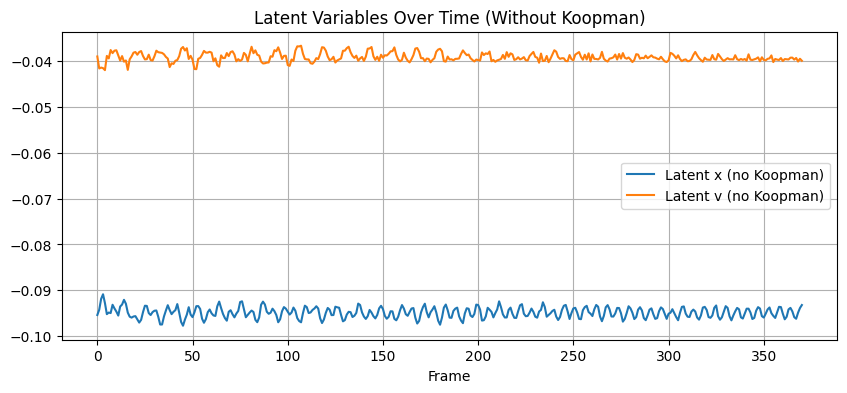

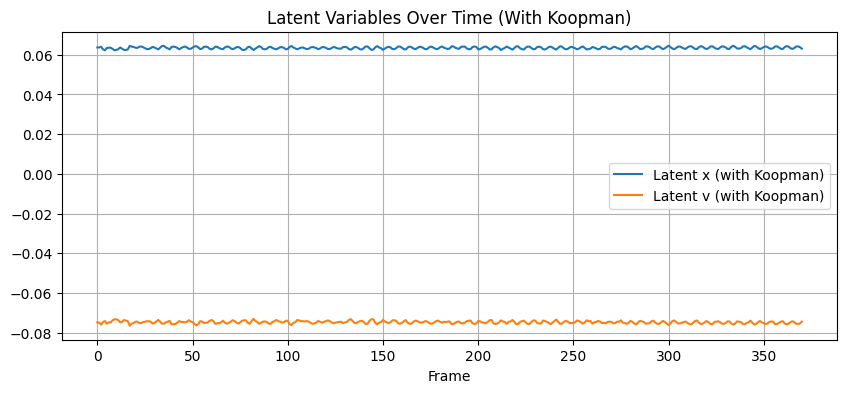

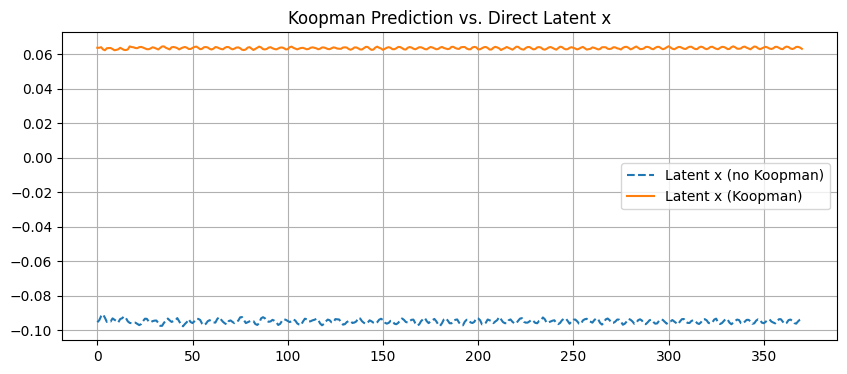

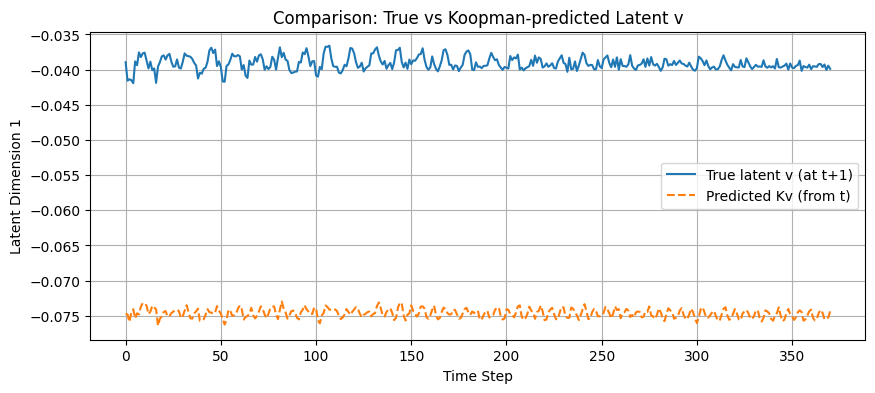

In [13]:
import matplotlib.pyplot as plt
import numpy as np

latent_vars_no_k = np.array(latent_vars_no_k_history)
latent_vars_k = np.array(latent_vars_k_history)

latent_x_no_k = latent_vars_no_k[:, 0]
latent_v_no_k = latent_vars_no_k[:, 1]

latent_x_k = latent_vars_k[:, 0]
latent_v_k = latent_vars_k[:, 1]

plt.figure(figsize=(10, 4))
plt.plot(latent_x_no_k, label='Latent x (no Koopman)')
plt.plot(latent_v_no_k, label='Latent v (no Koopman)')
plt.title('Latent Variables Over Time (Without Koopman)')
plt.xlabel('Frame')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(latent_x_k, label='Latent x (with Koopman)')
plt.plot(latent_v_k, label='Latent v (with Koopman)')
plt.title('Latent Variables Over Time (With Koopman)')
plt.xlabel('Frame')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(latent_vars_no_k[:, 0], label='Latent x (no Koopman)', linestyle='--')
plt.plot(latent_vars_k[:, 0], label='Latent x (Koopman)', linestyle='-')
plt.title('Koopman Prediction vs. Direct Latent x')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(latent_vars_no_k_history[:, 1], label="True latent v (at t+1)", linestyle='-')
plt.plot(latent_vars_k_history[:, 1], label="Predicted Kv (from t)", linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Latent Dimension 1")
plt.title("Comparison: True vs Koopman-predicted Latent v")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNEncoder(nn.Module):
    def __init__(self, input_shape, feature_dim):
        super(CNNEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self._get_conv_output(input_shape)
        self.fc = nn.Linear(self.num_flat_features, feature_dim)

    def _get_conv_output(self, shape):
        bs = 1
        input_tensor = torch.randn(bs, *shape)
        with torch.no_grad():
            output_feat = self.conv(input_tensor)
        self.conv_shape = output_feat.shape[1:]
        self.num_flat_features = output_feat.view(bs, -1).size(1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class CNNDecoder(nn.Module):
    def __init__(self, feature_dim, conv_shape):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ELU(),
            nn.Linear(128, int(torch.prod(torch.tensor(conv_shape))))
        )
        self.conv_shape = conv_shape
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), *self.conv_shape)
        return self.deconv(x)


class CNN_LSTM_Autoencoder(nn.Module):
    def __init__(self, input_shape, latent_dim=2, lstm_hidden=64):
        super(CNN_LSTM_Autoencoder, self).__init__()
        self.encoder = CNNEncoder(input_shape, feature_dim=128)
        self.lstm = nn.LSTM(input_size=128, hidden_size=latent_dim, batch_first=True)
        self.decoder = None

        dummy_input = torch.randn(1, *input_shape)
        dummy_encoded = self.encoder(dummy_input)
        self.decoder = CNNDecoder(latent_dim, self.encoder.conv_shape)

    def forward(self, x_seq):
        B, T, C, H, W = x_seq.shape
        encoded_seq = []
        for t in range(T):
            frame = x_seq[:, t]
            encoded = self.encoder(frame)
            encoded_seq.append(encoded)
        encoded_seq = torch.stack(encoded_seq, dim=1)

        latent_seq, _ = self.lstm(encoded_seq)

        decoded_seq = []
        for t in range(T):
            decoded = self.decoder(latent_seq[:, t])
            decoded_seq.append(decoded)
        decoded_seq = torch.stack(decoded_seq, dim=1)

        return decoded_seq, latent_seq

In [15]:
def train_cnn_lstm_autoencoder(model, images_tensor, num_epochs=50, lr=1e-3):
    import torch.optim as optim
    import torch.nn as nn
    import matplotlib.pyplot as plt

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.train()
    losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon, latent_seq = model(images_tensor)
        loss = loss_fn(recon, images_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

    return losses, latent_seq.detach()

def plot_losses(losses):
    import matplotlib.pyplot as plt
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss')
    plt.title('Training Loss over Time')
    plt.grid(True)
    plt.show()

Epoch 1/50, Loss: 0.889191
Epoch 2/50, Loss: 0.869529
Epoch 3/50, Loss: 0.851046
Epoch 4/50, Loss: 0.831861
Epoch 5/50, Loss: 0.809795
Epoch 6/50, Loss: 0.782724
Epoch 7/50, Loss: 0.748878
Epoch 8/50, Loss: 0.706753
Epoch 9/50, Loss: 0.655699
Epoch 10/50, Loss: 0.597312
Epoch 11/50, Loss: 0.536677
Epoch 12/50, Loss: 0.483429
Epoch 13/50, Loss: 0.450188
Epoch 14/50, Loss: 0.439859
Epoch 15/50, Loss: 0.431058
Epoch 16/50, Loss: 0.405438
Epoch 17/50, Loss: 0.365424
Epoch 18/50, Loss: 0.323001
Epoch 19/50, Loss: 0.287447
Epoch 20/50, Loss: 0.261389
Epoch 21/50, Loss: 0.242294
Epoch 22/50, Loss: 0.225393
Epoch 23/50, Loss: 0.207241
Epoch 24/50, Loss: 0.186726
Epoch 25/50, Loss: 0.164773
Epoch 26/50, Loss: 0.143769
Epoch 27/50, Loss: 0.126352
Epoch 28/50, Loss: 0.113828
Epoch 29/50, Loss: 0.104696
Epoch 30/50, Loss: 0.095716
Epoch 31/50, Loss: 0.084969
Epoch 32/50, Loss: 0.073297
Epoch 33/50, Loss: 0.062836
Epoch 34/50, Loss: 0.055116
Epoch 35/50, Loss: 0.050238
Epoch 36/50, Loss: 0.047203
E

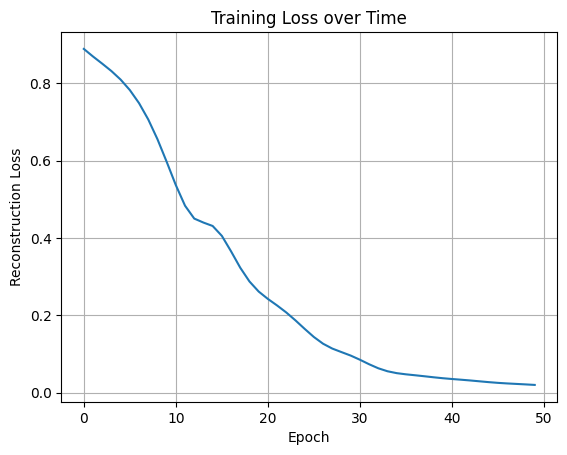

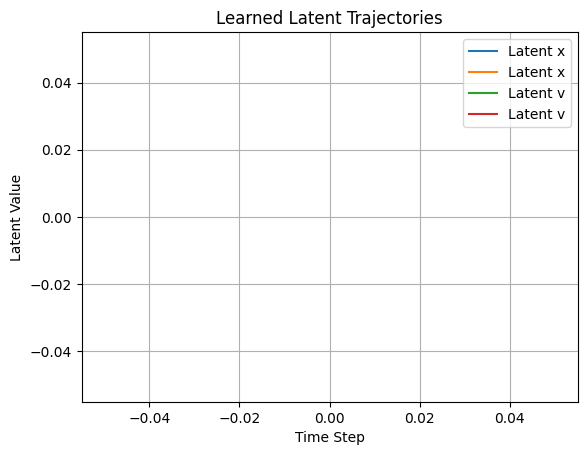

In [20]:
import matplotlib.pyplot as plt
images_tensor = torch.load('/content/image_tensors.pt')
images_tensor = images_tensor.unsqueeze(0)
sample_shape = tuple(images_tensor[0, 0].shape)
model = CNN_LSTM_Autoencoder(input_shape=sample_shape, latent_dim=2)
losses, latent_seq = train_cnn_lstm_autoencoder(model, images_tensor, num_epochs=50, lr=1e-3)
plot_losses(losses)

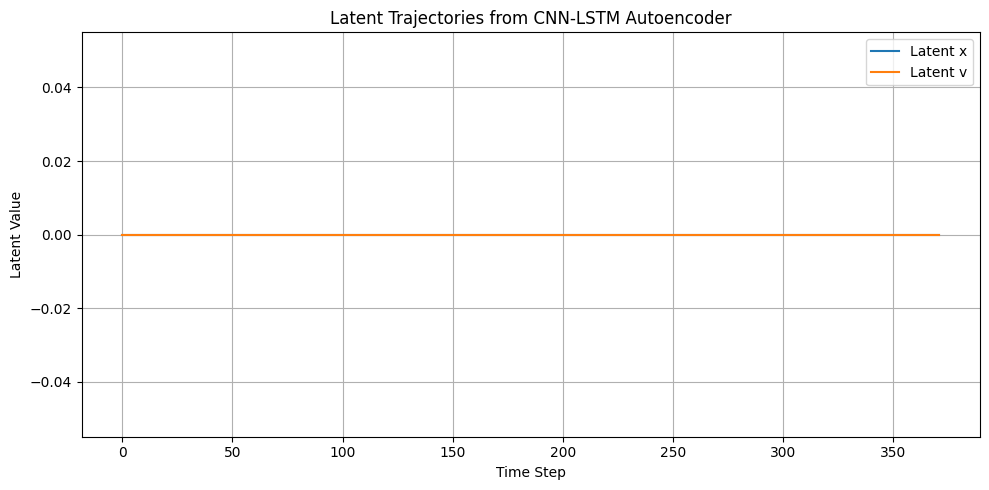

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Convert latent sequence to NumPy array
latent_seq_np = latent_seq.squeeze(0).cpu().numpy()  # shape: (T, 2)

# Plot latent x (position) and v (velocity)
plt.figure(figsize=(10, 5))
plt.plot(latent_seq_np[:, 0], label='Latent x')
plt.plot(latent_seq_np[:, 1], label='Latent v')
plt.title("Latent Trajectories from CNN-LSTM Autoencoder")
plt.xlabel("Time Step")
plt.ylabel("Latent Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


def train_cnn_lstm_autoencoder(model, images_tensor, num_epochs=50, lr=1e-3,
                                lambda_phys=10, lambda_damp=5, lambda_energy=5,
                                lambda_orth=1, lambda_smooth=0.1, alpha=0.0292, beta=0.0025):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    losses = []
    latent_history = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        recon_seq, latent_seq = model(images_tensor)
        recon_seq = recon_seq.squeeze(0)
        latent_seq = latent_seq.squeeze(0)

        reconstruction_loss = loss_fn(recon_seq, images_tensor.squeeze(0))

        x = latent_seq[:, 0]
        v = latent_seq[:, 1]

        dx_dt = x[1:] - x[:-1]
        phys_loss = lambda_phys * F.mse_loss(dx_dt, v[:-1])

        dv_dt = v[1:] - v[:-1]
        expected_acc = -alpha * x[1:] - beta * v[1:]
        damp_loss = lambda_damp * F.mse_loss(dv_dt, expected_acc)

        energy = x**2 + v**2
        energy_diff = energy[1:] - energy[:-1]
        energy_decay_loss = lambda_energy * F.relu(energy_diff).mean()

        orthogonality_loss = lambda_orth * torch.mean(x * v)

        smoothness = lambda_smooth * torch.mean((latent_seq[1:] - latent_seq[:-1])**2)

        total_loss = reconstruction_loss + phys_loss + damp_loss + energy_decay_loss + orthogonality_loss + smoothness
        total_loss.backward()
        optimizer.step()

        losses.append(total_loss.item())
        latent_history.append(latent_seq.detach().cpu())
        print(f"Epoch {epoch}, Loss: {total_loss.item():.4f}")

    return losses, torch.stack(latent_history)

In [31]:
images_tensor = torch.load('/content/image_tensors.pt')
images_tensor = images_tensor.unsqueeze(0)

sample_shape = tuple(images_tensor[0, 0].shape)

model = CNN_LSTM_Autoencoder(input_shape=sample_shape, latent_dim=2)

losses, latent_seq = train_cnn_lstm_autoencoder(
    model,
    images_tensor,
    num_epochs=50,
    lr=1e-3,
    lambda_phys=0.5,
    lambda_damp=0.5,
    lambda_energy=0.5,
    lambda_orth=0.1,
    lambda_smooth=0.05
)

Epoch 0, Loss: 0.9555
Epoch 1, Loss: 0.9216
Epoch 2, Loss: 0.8953
Epoch 3, Loss: 0.8732
Epoch 4, Loss: 0.8503
Epoch 5, Loss: 0.8260
Epoch 6, Loss: 0.8001
Epoch 7, Loss: 0.7714
Epoch 8, Loss: 0.7380
Epoch 9, Loss: 0.6984
Epoch 10, Loss: 0.6510
Epoch 11, Loss: 0.5947
Epoch 12, Loss: 0.5291
Epoch 13, Loss: 0.4558
Epoch 14, Loss: 0.3787
Epoch 15, Loss: 0.3042
Epoch 16, Loss: 0.2434
Epoch 17, Loss: 0.2095
Epoch 18, Loss: 0.2076
Epoch 19, Loss: 0.2187
Epoch 20, Loss: 0.2167
Epoch 21, Loss: 0.1929
Epoch 22, Loss: 0.1554
Epoch 23, Loss: 0.1169
Epoch 24, Loss: 0.0869
Epoch 25, Loss: 0.0694
Epoch 26, Loss: 0.0628
Epoch 27, Loss: 0.0631
Epoch 28, Loss: 0.0659
Epoch 29, Loss: 0.0680
Epoch 30, Loss: 0.0678
Epoch 31, Loss: 0.0651
Epoch 32, Loss: 0.0604
Epoch 33, Loss: 0.0549
Epoch 34, Loss: 0.0498
Epoch 35, Loss: 0.0460
Epoch 36, Loss: 0.0437
Epoch 37, Loss: 0.0422
Epoch 38, Loss: 0.0407
Epoch 39, Loss: 0.0382
Epoch 40, Loss: 0.0347
Epoch 41, Loss: 0.0308
Epoch 42, Loss: 0.0273
Epoch 43, Loss: 0.024

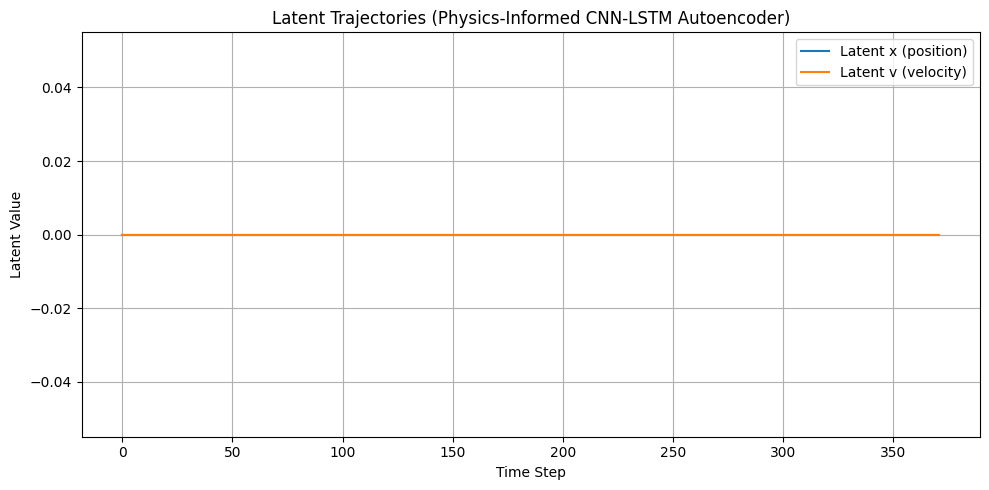

In [32]:
import matplotlib.pyplot as plt
import numpy as np

latent_seq_np = latent_seq[-1].cpu().numpy()


plt.figure(figsize=(10, 5))
plt.plot(latent_seq_np[:, 0], label='Latent x (position)')
plt.plot(latent_seq_np[:, 1], label='Latent v (velocity)')
plt.title("Latent Trajectories (Physics-Informed CNN-LSTM Autoencoder)")
plt.xlabel("Time Step")
plt.ylabel("Latent Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class CNNTemporalAutoencoder(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(CNNTemporalAutoencoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )

        dummy_input = torch.randn(1, *input_shape)
        with torch.no_grad():
            encoded = self.encoder_cnn(dummy_input)
        self.cnn_feat_shape = encoded.shape[1:]
        self.flat_feat_dim = encoded.view(1, -1).shape[1]

        self.temporal_encoder = nn.Sequential(
            nn.Conv1d(self.flat_feat_dim, latent_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.temporal_decoder = nn.Sequential(
            nn.Conv1d(latent_dim, self.flat_feat_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        T = x.shape[1]
        encodings = []

        for t in range(T):
            encoded_frame = self.encoder_cnn(x[:, t])
            encodings.append(encoded_frame.view(x.size(0), -1))
        enc_seq = torch.stack(encodings, dim=2)

        latent_seq = self.temporal_encoder(enc_seq)
        decoded_seq = self.temporal_decoder(latent_seq)

        recon_frames = []
        for t in range(T):
            feat = decoded_seq[:, :, t].view(x.size(0), *self.cnn_feat_shape)
            recon_frame = self.decoder_cnn(feat)
            recon_frames.append(recon_frame)

        recon = torch.stack(recon_frames, dim=1)
        return recon, latent_seq

In [34]:
def train_cnn_1dconv_autoencoder(model, images_tensor, num_epochs=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.train()
    losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon, latent_seq = model(images_tensor)
        loss = loss_fn(recon, images_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

    return losses, latent_seq.detach()

In [35]:
images_tensor = torch.load('/content/image_tensors.pt')
images_tensor = images_tensor.unsqueeze(0)
input_shape = tuple(images_tensor[0, 0].shape)

model = CNNTemporalAutoencoder(input_shape=input_shape, latent_dim=2)
losses, latent_seq = train_cnn_1dconv_autoencoder(model, images_tensor)

Epoch 1/50, Loss: 0.817431
Epoch 2/50, Loss: 0.801223
Epoch 3/50, Loss: 0.786373
Epoch 4/50, Loss: 0.772368
Epoch 5/50, Loss: 0.759040
Epoch 6/50, Loss: 0.746184
Epoch 7/50, Loss: 0.733662
Epoch 8/50, Loss: 0.721327
Epoch 9/50, Loss: 0.709066
Epoch 10/50, Loss: 0.696785
Epoch 11/50, Loss: 0.684431
Epoch 12/50, Loss: 0.671957
Epoch 13/50, Loss: 0.659314
Epoch 14/50, Loss: 0.646508
Epoch 15/50, Loss: 0.633567
Epoch 16/50, Loss: 0.620501
Epoch 17/50, Loss: 0.607319
Epoch 18/50, Loss: 0.594043
Epoch 19/50, Loss: 0.580696
Epoch 20/50, Loss: 0.567297
Epoch 21/50, Loss: 0.553872
Epoch 22/50, Loss: 0.540455
Epoch 23/50, Loss: 0.527073
Epoch 24/50, Loss: 0.513744
Epoch 25/50, Loss: 0.500500
Epoch 26/50, Loss: 0.487363
Epoch 27/50, Loss: 0.474360
Epoch 28/50, Loss: 0.461516
Epoch 29/50, Loss: 0.448855
Epoch 30/50, Loss: 0.436401
Epoch 31/50, Loss: 0.424172
Epoch 32/50, Loss: 0.412188
Epoch 33/50, Loss: 0.400460
Epoch 34/50, Loss: 0.389006
Epoch 35/50, Loss: 0.377839
Epoch 36/50, Loss: 0.366965
E

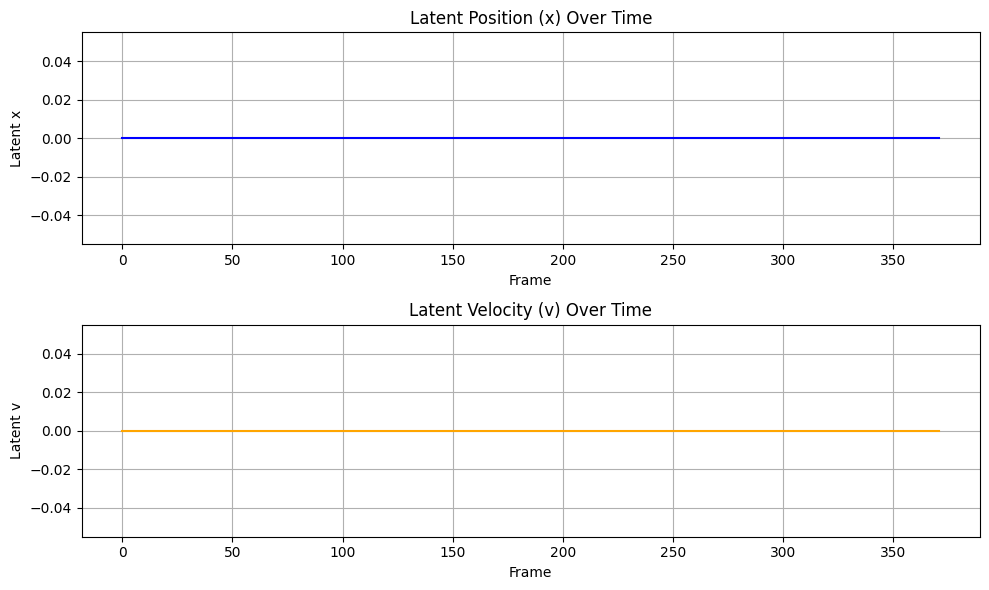

In [40]:
import matplotlib.pyplot as plt
import numpy as np


latent_seq_np = latent_seq.squeeze().detach().cpu().numpy()


if latent_seq_np.shape[-1] != 2:
    latent_seq_np = latent_seq_np.reshape(-1, 2)

latent_x = latent_seq_np[:, 0]
latent_v = latent_seq_np[:, 1]


plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(latent_x, label='Latent x', color='blue')
plt.title("Latent Position (x) Over Time")
plt.xlabel("Frame")
plt.ylabel("Latent x")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(latent_v, label='Latent v', color='orange')
plt.title("Latent Velocity (v) Over Time")
plt.xlabel("Frame")
plt.ylabel("Latent v")
plt.grid(True)

plt.tight_layout()
plt.show()